# CartPole - a small recap

CartPole is an environment where we have a pole balancing "on its head" on a cart that we can push left or right (2 actions).

The state is defined by four quantities:
- position of the cart
- velocity of the cart
- angle of the pole
- velocity of the tip of the pole

### What we discovered last time:

A simple (but clever!) state aggregation reduces the $\mathbb{R}^4$ dimensional state-space into only $6$ different tilings, while keeping all necessary information to achieve a very efficient policy.

Recall that with state aggregation it is sufficient for the application of a RL algorithm to perform state aggregation "outside" the Reinforcement Learning algorithm, and provide the vector $x(s)$ *as if* they were the actual states $s$. (The possibility of achieving the best performance is another thing...)

## Let's focus only on the smart tiling.

The smart choice of features $x$ were:

- Disregard the position of the cart (aggregation does not depend on $s_1$)
- Disregard the velocity of the cart (aggregation does not depend on $s_2$)
- The states are divided into three separate bins w.r.t the angle of the pole ($s_3 < -0.03$, $-0.03 \leq  s_3 < 0.03$ and $0.03 \leq s_3$)
- The states are divided into two separate bins w.r.t. the velocity of the tip of the pole ($s_4 \leq 0$, $s_4 > 0$)

There are a total of $1\times1\times3\times2 = 6$ tiles.

In [1]:
!pip install gymnasium


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
env = gym.make('CartPole-v1')

def state_aggregate(state, binning, Nbinning):
        # Nbinning is a tuple (N1, N2, N3, N4), with #bins for each of the four dimensions
        # which define dimension of features
        x = np.zeros(Nbinning)
        
        # x_indexes is the (only) index equal to 1 as dictated by the formula 1(s in D_s)
        x_indexes = np.array([0,0,0,0], dtype='int')
        
        for i,s in enumerate(state):
            if s <= binning[i,0]:
                x_indexes[i] = 0
            elif s >= binning[i,1]:
                x_indexes[i] = Nbinning[i]-1
            else :
                x_indexes[i] = np.floor((s-binning[i,0])/(binning[i,1]-binning[i,0])*Nbinning[i])
                
        x[(*x_indexes,)] = 1
        
        xi = np.argmax(x.reshape(-1))
        
        return np.argmax(x), x, x_indexes 

In [3]:
# JUST A SIMPLER NOTATION!

s, _ = env.reset()
xi, x, x_index = state_aggregate(s, binning=np.array([[-1.,1.],[-2.5,2.5],[-0.09,0.09],[-3,3]]), Nbinning=(1,1,3,2))

print('state ', s)

print('Binning: Matrix form of the vector of features ', x)
print('Binning: indexes of vector of features ', x_index)

print('Proper vector of features ', x.flatten())
print('Id of vector of features (#{} of 6)'.format( xi+1))

state  [0.00317639 0.0101998  0.02758036 0.04682343]
Binning: Matrix form of the vector of features  [[[[0. 0.]
   [0. 1.]
   [0. 0.]]]]
Binning: indexes of vector of features  [0 0 1 1]
Proper vector of features  [0. 0. 0. 1. 0. 0.]
Id of vector of features (#4 of 6)


Let us check if the Smart Policy is actually working.
https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 

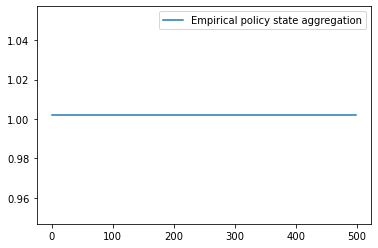

In [4]:
# Empirical, optimal Policy
optimal_policy = np.array([[1,0],  #  theta < -0.03, omega <0 -> Left
                           [1,0],  #  theta < -0.03, omega >0 -> Left
                           [1,0],  # |theta| < 0.03, omega <0 -> Left
                           [0,1],  # |theta| < 0.03, omega >0 -> Right
                           [0,1],  #  theta > 0.03,  omega <0 -> Right
                           [0,1]]) #  theta > 0.03,  omega >0 -> Right
                         
                    
n_episodes = 500
time_limit = 500
count = 0
gamma = 1


                    # pos cart / vel cart /  ang pole /  rot pole
                    # min max  / min max  /  min max  /  min max
binning = np.array([[-0.5,0.5],[-0.5,0.5],[-0.09,0.09],[-0.5,0.5]])
Nbinning=(1,1,3,2)

performance_traj_optimal = np.zeros(n_episodes)

# EVALUATIONS OF POLICY FOR N_EPISODES.
for i in range(n_episodes):
    done = False

    if (i%10==0):
        print(i, end=' ')

    time_horizon = 500
    
    # Get state s and feature vector x(s)
    s, _ = env.reset()
    x, _, _ = state_aggregate(s, binning, Nbinning)
    count = 0
    while not done:

        # keeping track for convergence
        count += 1
        
        # Select action from Optimal Policy
        a = np.argmax(optimal_policy[x])

        # Evolve one step        
        new_s, r, done, info, _ = env.step(a)
        new_x, _, _ = state_aggregate(new_s, binning, Nbinning)
        
        # Keeps track of performance for each episode
        performance_traj_optimal[i] += r/time_horizon
        x = new_x
        if count > time_limit :
            done = True
            
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), performance_traj_optimal, label='Empirical policy state aggregation')
ax.legend()

# Policy Gradient

So far for *model-free* control we used the value functions to construct policies (the $\epsilon$-greedy policies, for example).


Even with value-approximation, where each state $s$ had a feature vector $x(s)$ which was used to construct an approximate $V(s, w) = f(x(s), w)$, the policy was only constructed after we had a way to approximate the value.


However **we are interested in the policy not in the value!** Can we not focus on it from the start?

There is a different approach, that in its basic form can even work _without the need of a value function_, be it approximate or exact. In this class of algorithms we work directly with the policy $\pi$, taken as a function over the feature vector $x(s)$ with some parameters $\theta$:

$$
\pi(a|s, \theta)
$$

(For convention and clarity, the parameters for the value are always $w$ and for the policy are always $\theta$.) 

The idea is that we are going to follow a policy $\pi(a|s, \theta)$, and we are going to update the parameters $\theta$ in order to solve our ultimate goal: maximize the discounted reward.

$$
G = \mathbb{E}[\sum_{t=0}^{\infty} \gamma^t R_{t+1}]
$$

But how does $G$ depend on the policy $\pi(a|s, \theta)$? 

How does it depend on the parameters $\theta$? 

Can I calculate the gradient $\nabla_{\theta} G$?



### The Policy Gradient Theorem.

If the model is known, one idea is to use the probabilities of transitions and reward to perform explicit gradient calculations.
Fortunately, there is a way to estimate ${\nabla_{\theta} G}$ *even in absence* of a model, thanks to the Policy Gradient Method. In its most simple form, we have that:


$$
\nabla_{\theta} G = \mathbb{E}\big[\,\, Q_{\pi}(S,A)\nabla_{\theta}\,\,\text{log}\left(\pi(A|S, \theta)\right) \,\, |\,\, S\sim \eta, A\sim \pi_{\theta}\big]
$$

As always we can build any estimator $\hat{Q}$ of the (state,action) pair function, and then use it to construct the gradient. Even if the expression seems complex, it has a simple underlying message. 

$$
\hat{\nabla_{\theta} G} = \hat{Q}_t \nabla_{\theta} \,\, \text{log}\left(\pi(A_t|S_t, \theta)\right)
$$

Simply put: 

*The gradient of the overall performance $G$ tells us how to change the parameters $\theta$* 
- *i) by how the policy depends on them  ($\nabla_{\theta}\pi(A|S, \theta)$)* 
- *ii) by how well (I think) this policy is performing ($\hat{Q}_t$).*

#### Different estimators

Which estimator we use in conjunction with the PG theorem will determine the type of algorithm. Today we will see examples from two different *branches*:
- Actor-only (here, the estimator will be MonteCarlo)
- Actor-Critic, where we perform some degree of bootstrapping.

## Soft-Max Policies

But first, how can we construct parametrized policies $\pi(a|s,\theta)$?

One simple *tabular* parameterization for the policy is to have a weight $\theta$ for each couple $(s, a) \rightarrow \theta_{s,a}$. The policy is then constructed as:

$$
\pi_{\theta}(a,s) = \frac{e^{\theta_{a,s}}}{\sum_{a'} e^{\theta_{a',s}}}
$$

(The denominator is simply to ensure that the sum of all probabilities add up to one). 

- NOTE: If I add/subtract a constant term $A$ to all $\theta$, the relative probabilities do not change, I just multiply by $e^A$ both in the numerator and in the denominator...  

This is called *"soft-max"*, because even if it can parametrized probabilities as close to one as one wishes, it has always a finite probability to do the "sub-optimal" choice. *From now on all policies will be of this kind*.


Remember that in the PG theorem we have $\nabla_{\theta} \text{log } \pi(a | s, \theta)$. 
This is a vector of partial derivatives for all $\theta$ parameters (which are $|S| \times |A|$):

$$
    \frac{\partial \text{log } \pi(A_t | S_t)}{\partial \theta_{a,s}} = \left\{
    \begin{array}{clll}
        & 1-\pi(A_t|S_t)  \,\,\,& if \,\, a = A_t, s = S_t \\[2ex]
        & - \pi(A_t|S_t) \,\,\,& if \,\, a \neq A_t, s = S_t \\[2ex]
        & 0 \,\,\,& if \,\, a \neq A_t, s \neq S_t \\[2ex]
\end{array}
    \right.
$$

An important fact is that this parametrization allows in a rather natural way the possibility of having mixed policies, i.e. different finite probabilities for different actions. With perfect state-knowledge this is not important (optimal policy is always deterministic), but with value approximation this is *very* helpful!


(Another very common choice nowaday for parametrized policies, which we will not explore here, is ANNs. Check the material here for some very illuminating material https://spinningup.openai.com/en/latest/ ) 


# Actor-Only Algorithms

### REINFORCE: Policy Gradient with MonteCarlo

This algorithm uses the MonteCarlo estimator for the value function.
This means that before an update of the policy can be done via the parameters $\theta$, we have to wait until time $T$ where the episode is terminated, and then calculate the return for each time step.

$$
\hat{G_t} = \sum_{k=t}^{T} \gamma^{k-t} R_{k+1}
$$

And use it in:

$$
\hat{\nabla_{\theta} G} = \hat{G}_t \nabla_{\theta} \,\, \text{log}\left(\pi(A_t|S_t, \theta)\right)
$$

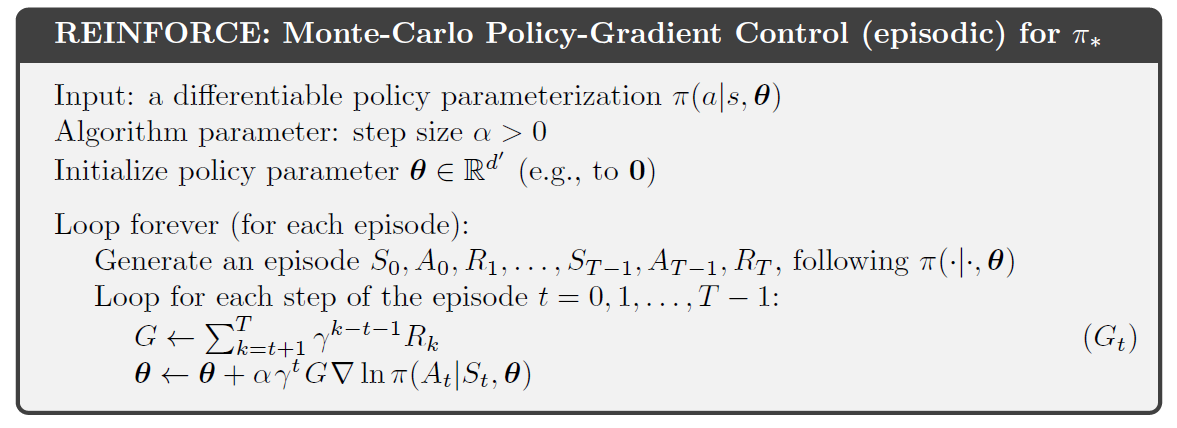

## What *new* parts do we need in our RL class?


1) A way to construct a policy from the parameters $\theta$:
    function "get_policy", which returns the soft-max policy 

$$
\pi_{\theta}(a,s) = \frac{e^{\theta_{a,s}}}{\sum_{a'} e^{\theta_{a',s}}}
$$

2) A way to select a (random) action given the policy constructed from the parameters $\theta$:
    function "get_action", which returns a random action given the policy above 


3) A way to update the parameters $\theta$ when the episode is done. (Gradient Ascent with $\hat{\nabla_{\theta} G}$!)
    function "single_episode_update". 


In [5]:
# Just a very nice function to have :)
import scipy.signal
import numpy as np

# Ausiliary function
def discount_cumsum(x, discount):
    """
    magic for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [6]:
class REINFORCE():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_a=0.01):
        """
        Calculates optimal policy using Policy Gradient with MonteCarlo returns
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # the learning rate for actor
        self.lr_a = lr_a
        
        # where to save parameters for policy
        self.Theta = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_episode_update(self, traj_states, traj_rew, traj_act):
        """
        Uses a single trajectory to update the values.
        Calculate the returns.
        Calculate the delta_Theta as in the REINFORCE pseudo-code!
        """
        
        # calculates the returns for each step: DISCOUNTed CUMulative SUM.
        ret = discount_cumsum(traj_rew, gamma)
        delta_Theta = np.zeros( (*self.space_size, self.action_size) )
        
        for t_step, (s, a) in enumerate(zip(traj_states, traj_act)):    
            s = [s]
            
            # policy in s
            policy = self.get_policy(s)
            
            # The only non-zero change is for actions in the state s
            for act in range(self.action_size):
                if (a == act):
                    delta_Theta[(*s, act)] += self.lr_a * ret[t_step] * (1 - policy[act])
                else:
                    delta_Theta[(*s, act)] += self.lr_a * ret[t_step] * (- policy[act])
          
        self.Theta +=  delta_Theta 
    # ---------------------
    def get_action(self, s):
        """
        Chooses action at random using policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 

        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.max(self.Theta[(*s,)])
        
        # P(a_i) = exp(theta_i) / sum_j exp(theta_j) 
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
        
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
    
        # ---------------------
    def get_policy(self, s):
        """
        Returns policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 
        
        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.max(self.Theta[(*s,)])
        
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
            
        return prob_actions

# Let us run the REINFORCE algorithm

Let us run the cartpole with the "smart tiling" and learn the correct policy with REINFORCE.
Note: now we will effectively learn only  $6\times2$ parameters, one for each state and one for each action. This is because we are already doing state aggregation.


0 c 14, t 648, tt 648, r 0.021604938271604937
c 15, t 22, tt 22, r 0.6818181818181818
c 16, t 641, tt 641, r 0.0249609984399376
c 15, t 916, tt 916, r 0.016375545851528377
c 21, t 239, tt 239, r 0.08786610878661084
c 12, t 12, tt 12, r 1.0
c 29, t 1014, tt 1014, r 0.028599605522682467
c 33, t 357, tt 357, r 0.09243697478991597
c 15, t 76, tt 76, r 0.19736842105263153
c 21, t 158, tt 158, r 0.13291139240506336
10 c 22, t 73, tt 73, r 0.3013698630136986
c 16, t 875, tt 875, r 0.01828571428571429
c 21, t 139, tt 139, r 0.1510791366906475
c 28, t 90, tt 90, r 0.31111111111111106
c 18, t 138, tt 138, r 0.13043478260869568
c 20, t 58, tt 58, r 0.3448275862068965
c 28, t 511, tt 511, r 0.0547945205479452
c 40, t 223, tt 223, r 0.1793721973094172
c 14, t 578, tt 578, r 0.024221453287197228
c 36, t 1619, tt 1619, r 0.022235948116121056
20 c 17, t 201, tt 201, r 0.0845771144278607
c 17, t 2790, tt 2790, r 0.006093189964157704
c 13, t 124, tt 124, r 0.10483870967741932
c 18, t 1220, tt 1220, r 0.

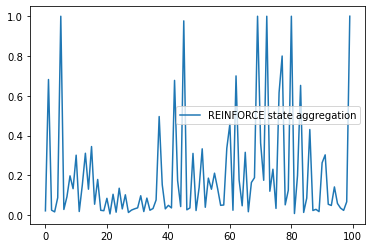

In [18]:
# REINFORCE: Actor-only MonteCarlo solving CartPole (with state aggregation).

n_episodes = 100


binning = np.array([[-0.5,0.5],[-0.5,0.5],[-0.09,0.09],[-0.5,0.5]])
Nbinning=(1,1,3,2)


# Initialize 
lr_a_0 = 0.0003

# Stochastically determined time-horizon!
# Episode can end either by terminal state OR "killed" at each step with probability 1-gamma.
gamma_discount = 1

# Initialize algorithm
RL = REINFORCE(space_size=[6], 
                      action_size=2,
                      gamma=1, 
                      lr_a=lr_a_0)


performance_traj_REINFORCE = np.zeros(n_episodes)


tstar = 25000
gamma = 0.998

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    traj_act = np.empty(0, dtype=int)
    traj_states = np.empty(0, dtype=int)
    traj_rew = np.empty(0)
    done = False

    count = 0
    
    if (i%10==0):
        print(i, end=' ')

    # The environment has a fixed horizon, but the RL algorithm should not have it!
    # I change the one from the algorithm to be stochastic with gamma (gamma=0.998)
    
    # Get state s and feature vector x(s)
    s, _ = env.reset()
    
    time_horizon = np.random.geometric(1-gamma)
    env._max_episode_steps = time_horizon
    
    x, _, _ = state_aggregate(s, binning, Nbinning)
    
    
    while not done:

        # keeping track for convergence
        count += 1
        
        # Keep trajectory of FEATURE VECTORS (states)
        traj_states = np.append(traj_states, [x])

        # Select action with Soft-max
        a = RL.get_action([x])
        # Keep trajectory of ACTIONS
        traj_act = np.append(traj_act, a)

        # Evolve one step        
        new_s, r, done, _, info = env.step(a)
        x, _, _ = state_aggregate(new_s, binning, Nbinning)
        
        # Keep trajectory of REWARDS
        traj_rew = np.append(traj_rew, r)
        
        # Keeps track of performance for each episode
        performance_traj_REINFORCE[i] += r/time_horizon
        
        
        
        if count > tstar:
            # UPDATE OF LEARNING FOR ACTOR
            RL.lr_a = lr_a_0 /(1 + 0.002*(count - tstar)**0.75)
            
        if count > (time_horizon-1) :
            done = True
    
    print(f"c {count}, t {time_horizon}, tt {env._max_episode_steps}, r {performance_traj_REINFORCE[i]}")
    
    RL.single_episode_update( traj_states, traj_rew, traj_act)
    #print('evolution of policy for state 2 = ', RL.get_policy([2]))    
        
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), performance_traj_REINFORCE, label='REINFORCE state aggregation')
ax.legend()

optimal_policy = np.array([[1,0],  # theta < -0.03, w<0 -> Left
                           [1,0],  # theta < -0.03, w>0 -> Left
                           [1,0],  # |theta| < 0.03, w<0 -> Left
                           [0,1],  # |theta| < 0.03, w>0 -> Right
                           [0,1],  # theta > 0.03, w<0 -> Right
                           [0,1]]) # theta > 0.03, w>0 -> Right
print('\n')
for i in range(6):
    print('\n', RL.get_policy([i]), 'optimal is ', optimal_policy[i])


In [10]:
performance_traj_REINFORCE

array([2.22222222e-02, 1.09756098e-01, 9.72222222e-02, 1.45454545e+00,
       4.64285714e-02, 1.32530120e-01, 1.66112957e-02, 2.27920228e-02,
       5.92592593e-02, 8.84955752e-02, 1.64654226e-02, 7.57002271e-03,
       1.84135977e-02, 6.20689655e-02, 1.85714286e-02, 6.88259109e-02,
       4.67836257e-02, 8.18505338e-02, 3.23741007e-02, 2.01680672e-02,
       3.20121951e-02, 1.90000000e+01, 3.16455696e-02, 3.01455301e-02,
       2.58620690e-01, 4.24448217e-02, 2.95454545e-01, 5.57620818e-02,
       1.21212121e-01, 8.33333333e-02, 3.36700337e-03, 1.68350168e-03,
       2.89017341e-03, 1.85873606e-03, 3.06748466e-03, 9.43396226e-03,
       1.00603622e-03, 3.57142857e-02, 2.22222222e-03, 9.34579439e-03,
       3.33333333e-02, 1.25628141e-03, 1.45348837e-03, 3.28947368e-03,
       1.02040816e-02, 2.52525253e-03, 1.42857143e-02, 2.80898876e-03,
       4.16666667e-02, 2.38663484e-03, 1.17096019e-03, 1.88323917e-03,
       2.82725474e-04, 3.03030303e-02, 1.16279070e-02, 3.15457413e-03,
      

# Actor-Critic Algorithms

How can we avoid having to wait an entire episode to make a single change? Using bootstrap!
Again this is very reminescent to what we have being doing so far with Model-Free control.

In particular, we will be using "**Formulation 2**" (from Lecture 4)

$$
Q_\pi(s,a) = \mathbb{E}_{\pi}\bigg[ R_1 + \gamma V_\pi(S_1) \,\, \Big| \,\, S_0 = s, A_0 = a\bigg] \ .
$$



_"The expectation value of the immediate reward plus the discounted $V$-value of the following state $S_1$, when starting from state $s$, acting with action $a$ and then always following the policy $\pi$."_

Moreover, we will implement a baseline $b(s)$

$$
\nabla_{\theta} G = \mathbb{E}\big[\,\, \big(Q_{\pi}(S,A) - b(S)\big)\nabla_{\theta}\,\,\text{log}\left(\pi(A|S, \theta)\right) \,\, |\,\, S\sim \eta, A\sim \pi_{\theta}\big]
$$



We will use the baseline $b(s) = V_\pi(s)$, so that the estimation of the gradient will be:

$$
\hat{\nabla_{\theta} G} = [R_{t+1} + \gamma V_\pi(S_{t+1}) - V_\pi(S_t)] \nabla_{\theta} \,\, \text{log}\left(\pi(A_t|S_t, \theta)\right)\\
\hat{\nabla_{\theta} G} = \delta_{TD} \,\,\, \nabla_{\theta} \,\, \text{log}\left(\pi(A_t|S_t, \theta)\right)\\
$$

As last Friday we will perform tabular *Value-Approximation* with State-Aggregation, but this time we will approximate the value $V(s|w) = w^T x$ and not the $Q$-function. (The method is essentially identical.)

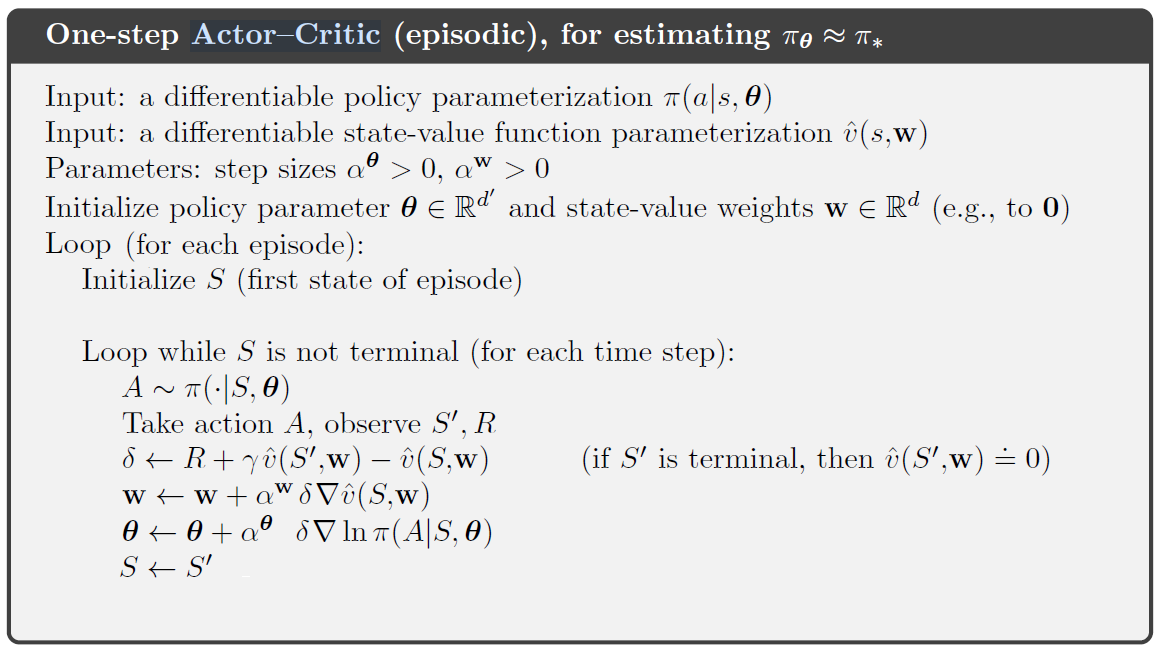

The idea is that as we continue to interact with the environment and collect trajectories, we learn the value-function $V$ *and* the we update $\theta$ to follow the gradient ascent for the goal $G$.

However, it is very important to note that there should is a hierarchy of **two time-scales**. A **fast** one, which is related to learning **values**, and a **slower one** which is related to learning **policies**.
Indeed ideally we should learn values with fixed policies, and change policies only when the proper values are reached. *If values are wrong, the updates for the policies are garbage!*

## What *new* parts do we need in our RL class?

Few things exactly as in the REINFORCE case
1) A way to construct a policy from the parameters $\theta$:
    function "get_policy", which returns the soft-max policy 

$$
\pi_{\theta}(a,s) = \frac{e^{\theta_{a,s}}}{\sum_{a'} e^{\theta_{a',s}}}
$$

2) A way to select a (random) action given the policy constructed from the parameters $\theta$:
    function "get_action", which returns a random action given the policy above 

The only differences is in the update part: function "single_step_update".
Note that now it is single *step* update and not single *episode* update! We can update at each step.

3) The function "single_step_update" now must deal with updates both of the $V_{\pi}$ estimator (via the parameters $w$, as in the state aggregation function approximation case) and of the policy (via the parameters $\theta$, using the Gradient Ascent with $\hat{\nabla_{\theta} G}$!). 



In [19]:
class ActorCritic():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v=0.01,
                 lr_a=0.001):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Approximate V-value for states S!
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size
        # action size
        self.action_size = action_size
        
        # the learning rate for value
        self.lr_v = lr_v
        # the learning rate for actor
        self.lr_a = lr_a
        
        # Stores the Value Approximation weights
        self.w = np.zeros((*self.space_size,))
        # Stores the Policy parametrization
        self.Theta = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference delta for V values.
        """
        
        # ---------------------
        # CRITIC UPDATE -------
        # ---------------------
        
        if done:
            # -----------------------
            delta = (r + 0 - self.w[(*s,)])
            
        else:
            # --------------------------
            delta = (r + 
                      self.gamma * self.w[(*new_s,)]
                                 - self.w[(*s,)])
            
        # --------------------
        self.w[(*s,)] += self.lr_v * delta
        
        # -------------------------
        # Now Actor update --------
        # -------------------------
        policy = self.get_policy(s)
            
        for act in range(self.action_size):
            # If the action "act" is that which was really chosen in the trajectory
            if (a == act):
                self.Theta[(*s, act) ] += self.lr_a * delta * (1 - policy[act])
            # Else if the action "act" has not been performed
            else:
                self.Theta[(*s, act) ] += self.lr_a * delta * (- policy[act])
        
    # ---------------------
    def get_action(self, s):
        """
        Chooses action at random using policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 

        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.mean(self.Theta[(*s,)])
        
        # Clip needed to avoid NaN.
        log_prob = np.clip(log_prob, -20, 20)
        
        # P(a_i) = exp(theta_i) / sum_j exp(theta_j) 
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
        
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
    
        # ---------------------
    def get_policy(self, s):
        """
        Returns policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 
        
        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.mean(self.Theta[(*s,)])
        
        # Clip needed to avoid NaN.
        log_prob = np.clip(log_prob, -20, 20)
        
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
            
        return prob_actions

Let's run it!

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

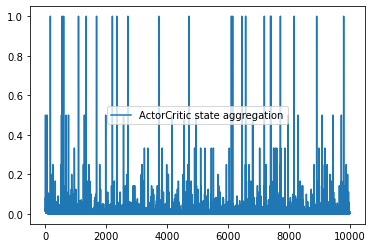

In [23]:
# ActorCritic: Bootstrapping to solve CartPole (with state aggregation).

n_episodes = 10000


binning = np.array([[-0.5,0.5],[-0.5,0.5],[-0.09,0.09],[-0.5,0.5]])
Nbinning=(1,1,3,2)


# Initialize learning rates
# Note the difference in values!
#Two time-scales!
lr_v_0 = 0.75
lr_a_0 = 0.08

lr_v = lr_v_0
lr_a = lr_a_0

# Stochastically determined time-horizon!
# Episode can end either by terminal state OR "killed" at each step with probability 1-gamma.
gamma_discount = 1

# Initialize algorithm
RL = ActorCritic(space_size=[6], 
                      action_size=2,
                      gamma=gamma_discount, 
                      lr_v=lr_v,
                      lr_a=lr_a)


performance_traj_ActorCritic = np.zeros(n_episodes)


tstar = 150000
gamma = 0.998


# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    traj_act = np.empty(0, dtype=int)
    traj_states = np.empty(0, dtype=int)
    traj_rew = np.empty(0)
    done = False
    
    if (i%10==0):
        print(i, end=' ')

    count = 0
    
    # Get state s and feature vector x(s)
    s, _ = env.reset()

    # Stochastically determined time-horizon for each episode!
    # I can't have a fixed horizon, but one that is stochastic with gamma (gamma=0.999)
    time_horizon = np.random.geometric(1-gamma)
    env._max_episode_steps = time_horizon
    
    x, _, _ = state_aggregate(s, binning, Nbinning)
    
    while not done:

        # keeping track for convergence
        count += 1
        
        # Select action with Soft-max
        a = RL.get_action([x])

        # Evolve one step        
        new_s, r, done, _, info = env.step(a)
        new_x, _, _ = state_aggregate(new_s, binning, Nbinning)
        
        # Keeps track of performance for each episode
        performance_traj_ActorCritic[i] += r/time_horizon
        
        # SINGLE STEP UPDATE    
        RL.single_step_update([x], a, r, [new_x], done)
        
        x = new_x
        
        if count > tstar:
            # UPDATE OF LEARNING
            RL.lr_v = lr_v_0 /(1 + 0.01*(count - tstar)**0.75)
            RL.lr_a = lr_a_0 /(1 + 0.01*(count - tstar)**0.75)
            
        if count > time_horizon -1  :
            done = True
            
print(count)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), performance_traj_ActorCritic, label='ActorCritic state aggregation')
ax.legend()

optimal_policy = np.array([[1,0],  # theta < -0.03, w<0 -> Left
                           [1,0],  # theta < -0.03, w>0 -> Left
                           [1,0],  # |theta| < 0.03, w<0 -> Left
                           [0,1],  # |theta| < 0.03, w>0 -> Right
                           [0,1],  # theta > 0.03, w<0 -> Right
                           [0,1]]) # theta > 0.03, w>0 -> Right

print('\n')
for i in range(6):
    print('\n', RL.get_policy([i]), 'optimal is ', optimal_policy[i])

## OPTIONAL: Natural Gradient!
### We will see Natural Gradient in the case of Dueling Agents.

With the Policy Gradient methods we are trying to change the parameters $\theta$ by "a small amount" $\alpha$ in the direction indicated by the gradient $\nabla_{\theta} G$.

generally speaking, when we are doing gradient descent for a function $f(x)$, we are doing a move in $x$, such that

$$
x_{t+1} = x_t - \alpha \nabla f(x_t)
$$

Which correspond to finding the minimum of an approximation of $f(x)$ around the current value $x_t$ using the local gradient:

$$
f_{approx}(x) = \alpha \nabla f(x_t) (x-x_t) + \frac{1}{2}|| x-x_t||^2
$$

Essentially we are "trusting" the evaluated gradient $\nabla f(x_t)$ only a bit, and we are asking for the $x$ not to go "far", penalizing them with $|| x-x_t||^2$.

The main point is that this penalty correspond to distances in the $x$ spaces over which we have no control, and could be very inhomogeneous!

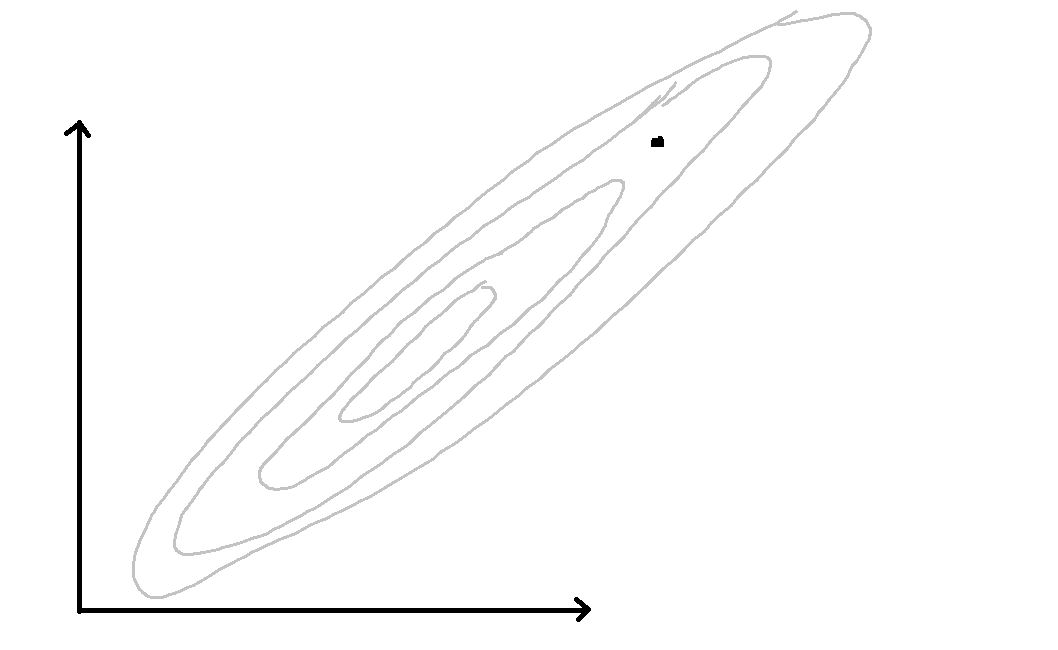

In our case, we are moving around the space of $\theta$, but we are not really interested in the euclidean distance between the parameters $||\theta' - \theta||^2$. They have no real effect on the agent. What changes things truly is the **policy**! 

So a more "natural" way to restrict the "motion" of $\theta$ is to penalize it with the effect on the policy themselves.

$$
|| \theta-\theta_t||^2 \longrightarrow D_{KL}(\, \pi(s|\theta) \, || \, \pi(s|\theta_t) \, )
$$

So we want to "move as quickly as possible in the direction of $\theta$ where policies do not change" and be "move cautiously" in directions where policies change fast.
It turns out that we can achieve this if instead of the gradient $\nabla$ we follow the **natural gradient** $\tilde{\nabla} = F[\theta]^{-1} \cdot \nabla$, where $F[\theta]$ is the Fisher Matrix, defined as:

$$
F[\theta]_{i,j} = \sum_a \pi(a) \frac{\partial \text{log} \pi(a)}{\partial \theta_i} \frac{\partial \text{log}\pi(a)}{\partial \theta_j}
$$


### Yes, ok... But how, in practice?

Let us consider the parametrization of the policies used so far, with $N$ parameters $(\theta_1, \theta_2, \dots, \theta_N)$ for $N$ actions. (Ignoring for simplicity the dependence on the state). 


$$
\begin{eqnarray}
\pi(a | \theta) &=& \pi(a) &= \frac{e^{\theta_a}}{\sum_j e^{\theta_j}} \\
\end{eqnarray}
$$

Let us recall that
$$
    \nabla_i \text{log}\pi(a) = \frac{\partial \text{log } \pi(a)}{\partial \theta_i} = \left\{
    \begin{array}{clll}
        & 1-\pi(i)  \,\,\,& \text{if} \,\, a = i \\[2ex]
        & - \pi(i) \,\,\,& \text{if} \,\, a \neq i \\[2ex]
\end{array}
    \right.
$$

In a more concise way, we have that

$$
\frac{\partial \text{log } \pi(a)}{\partial \theta_i} = \mathbb{1}_{(a=i)} - \pi(i) \\
$$

Now we can construct the Fisher Information Matrix. The $(i,j)^{th}$ element of the matrix is:

$$
\begin{eqnarray}
F[\theta]_{i,j} &=& \sum_a \pi_a \frac{\partial \text{log} \pi(a)}{\partial \theta_i} \frac{\partial \text{log}\pi(a)}{\partial \theta_j} \\
&=& \sum_a \pi(a) \big(\mathbb{1}_{(a=i)} - \pi(i)\big)\big(\mathbb{1}_{(a=j)} - \pi(j)\big) \\
&=& \sum_a \pi(a) \big(\mathbb{1}_{(a=i)}\mathbb{1}_{(a=j)} - \mathbb{1}_{(a=j)}\pi(i) - \mathbb{1}_{(a=i)}\pi(j) + \pi(j)\pi(i)\big) \\
&=& \pi(i) \mathbb{1}_{(i=j)} - \pi(j)\pi(i)
\end{eqnarray}
$$

One more step is needed!
As we write the natural gradient $\tilde{\nabla} = F[\theta]^-1 \nabla$ we can equivalently express the standard gradient as $F[\theta] \tilde{\nabla} = \nabla$. 
Expressing the matrix product explicitly for a single derivative $\partial/\partial{\theta_i} $ we have:

$$
\sum_j F[\theta]_{i,j} \tilde{\nabla}_j = \nabla_i = \partial/\partial{\theta_i}
$$

Let us now apply the natural gradient to $\text{log}(\pi(a))$ (where $a$ is the action which enters in the Action-Critic update):

$$
\begin{eqnarray}
\sum_j F[\theta]_{i,j} \tilde{\nabla}_j \text{log}(\pi(a))&=& \partial/\partial{\theta_i} \text{log}(\pi(a))\\
\sum_j (\pi(i) \mathbb{1}_{(i=j)} - \pi(j)\pi(i)) \left[ \tilde{\nabla}_j \text{log}(\pi(a)) \right] &=& \mathbb{1}_{(a=i)} - \pi(i)\\
\end{eqnarray}
$$

Solving the equation above, we can finally find the explicit expression for the natural gradient in the case of the soft-max policies.

$$
\tilde{\nabla}_j \text{log}(\pi(a)) = \frac{\mathbb{1}_{(a=j)}}{\pi(j)} 
$$

Notice what happens when $\pi \rightarrow 0$. The standard gradient goes also to $0$, and therefore the value $\theta$ is "stuck" there. However for the natural gradient if $\pi \rightarrow 0$ the corresponding update on $\theta$ can be potentially unbounded!

#### Recap on Natural Gradient

**PRO**: 
- Natural gradient does "move" on the space of probabilities, and does not suffer from very in-homogeneous spaces. This allows for a much faster convergence!

**CON**: 
- Expression for Fisher Matrix in general is not simple and needs iterative approximations
- Higher variance. When $\pi_j \rightarrow 0$ the update weight goes to infinity! Generally a "cutoff" is used $\frac{\mathbb{1}_{(a=j)}}{\pi(j) + \eta}$, with $\eta$ a small number.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

class ActorCritic_NaturalGradient():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v = 0.01,
                 lr_a = 0.01,
                 eta = 0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Approximate V-value for states S!
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size
        # action size
        self.action_size = action_size
        
        # the learning rate for value
        self.lr_v = lr_v
        # the learning rate for actor
        self.lr_a = lr_a
        
        # to diminuish variance
        self.eta = 0.01
        
        # Stores the Value Approximation weights
        self.w = np.zeros((*self.space_size,))
        # Stores the Policy parametrization
        self.Theta = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for V values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        
        # ---------------------
        # CRITIC UPDATE -------
        # ---------------------
        
        if done:
            # -----------------------
            delta = (r + 0 - self.w[(*s,)])
            
        else:
            # --------------------------
            delta = (r + 
                      self.gamma * self.w[(*new_s,)]
                                 - self.w[(*s,)])
            
        # --------------------
        self.w[(*s,)] += self.lr_v * delta 
        
        # -----------------------------------------------
        # Now Actor update with Natural Gradient --------
        # -----------------------------------------------
        policy = self.get_policy(s)
        
        # Natural Gradient: non-zero only for the action which has been selected!
        self.Theta[(*s, a) ] += self.lr_a * delta / (policy[a] + 0.001)

        
    # ---------------------
    def get_action(self, s):
        """
        Chooses action at random using policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 

        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.mean(self.Theta[(*s,)])
        
        # Clip needed to avoid NaN.
        log_prob = np.clip(log_prob, -20, 20)
        
        # P(a_i) = exp(theta_i) / sum_j exp(theta_j) 
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
        
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
    
        # ---------------------
    def get_policy(self, s):
        """
        Returns policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 
        
        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta[(*s,)] - np.mean(self.Theta[(*s,)])
        
        # Clip needed to avoid NaN.
        log_prob = np.clip(log_prob, -20, 20)
        
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
            
        return prob_actions

0 1000 2000 3000 4000 5000 35
[9.99967101e-01 3.28992382e-05] optimal is  [1 0]
[1.00000000e+00 4.03503332e-10] optimal is  [1 0]
[2.27402921e-04 9.99772597e-01] optimal is  [1 0]
[0.6119839 0.3880161] optimal is  [0 1]
[2.80648282e-05 9.99971935e-01] optimal is  [0 1]
[3.63614612e-05 9.99963639e-01] optimal is  [0 1]


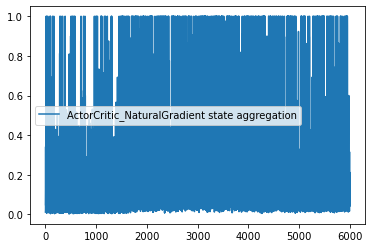

In [36]:
# ActorCritic with Natural Gradient: Bootstrapping to solve CartPole (with state aggregation).

n_episodes = 6000


binning = np.array([[-0.5,0.5],[-0.5,0.5],[-0.09,0.09],[-0.5,0.5]])
Nbinning=(1,1,3,2)


# Initialize 
lr_v_0 = 0.01
lr_a_0 = 0.002

lr_v = lr_v_0
lr_a = lr_a_0


# Stochastically determined time-horizon!
# Episode can end either by terminal state OR "killed" at each step with probability 1-gamma.
gamma_discount = 1

# Initialize algorithm
RL = ActorCritic_NaturalGradient(space_size=[6], 
                      action_size=2,
                      gamma=gamma_discount, 
                      lr_v=lr_v,
                      lr_a=lr_a)


performance_traj_ActorCritic_NaturalGradient = np.zeros(n_episodes)


tstar = 55000
gamma = 0.998

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    traj_act = np.empty(0, dtype=int)
    traj_states = np.empty(0, dtype=int)
    traj_rew = np.empty(0)
    done = False

    count = 0
    if (i%1000==0):
        print(i, end=' ')

    # Get state s and feature vector x(s)
    s, _ = env.reset()

    # Stochastically determined time-horizon for each episode!
    # I can't have a fixed horizon, but one that is stochastic with gamma (gamma=0.999)
    time_horizon = np.random.geometric(1-gamma)
    env._max_episode_steps = time_horizon
    
    x, _, _ = state_aggregate(s, binning, Nbinning)
    
    while not done:

        # keeping track for convergence
        count += 1
        
        # Select action with Soft-max
        a = RL.get_action([x])

        # Evolve one step        
        new_s, r, done, _, info = env.step(a)
        new_x, _, _ = state_aggregate(new_s, binning, Nbinning)
        
        # Keeps track of performance for each episode
        performance_traj_ActorCritic_NaturalGradient[i] += r/time_horizon
        
        # SINGLE STEP UPDATE    
        RL.single_step_update([x], a, r, [new_x], done)
        
        x = new_x
        
        if count > tstar:
            # UPDATE OF LEARNING
            RL.lr_v = lr_v_0 /(1 + 0.01*(count - tstar)**0.75)
            RL.lr_a = lr_a_0 /(1 + 0.01*(count - tstar)**0.75)

        if count > time_horizon -1 :
            done = True
        
print(count)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), performance_traj_ActorCritic_NaturalGradient, label='ActorCritic_NaturalGradient state aggregation')
ax.legend()

optimal_policy = np.array([[1,0],  # theta < -0.03, w<0 -> Left
                           [1,0],  # theta < -0.03, w>0 -> Left
                           [1,0],  # |theta| < 0.03, w<0 -> Left
                           [0,1],  # |theta| < 0.03, w>0 -> Right
                           [0,1],  # theta > 0.03, w<0 -> Right
                           [0,1]]) # theta > 0.03, w>0 -> Right

for i in range(6):
    print(RL.get_policy([i]), 'optimal is ', optimal_policy[i])